# Chapter 2: Loading and visualizing data

In [1]:
import configparser
from getpass import getuser
config = configparser.ConfigParser()
config.read(f"../config/{getuser()}.ini")
if len(config.sections()) == 0:
    config.read("config/default.ini")
DATA_PATH = config["Data"]["path"]

## Construct a DataFrame from the .json files

In [2]:
import os
import json
import pandas as pd

data = []

for file in os.listdir(DATA_PATH):
    if file.endswith(".json"):
        with open(os.path.join(DATA_PATH, file), "r") as f:
            data.append(json.load(f))

df = pd.DataFrame(data)
df["Time_Published"] = pd.to_datetime(df["Time_Published"])
df["Sentiment"] = df.apply(lambda x: 1 if x["Polarity"] > 0.1 else 0 if abs(x["Polarity"]) <= 0.1 else -1, axis=1)
print(df.shape)

(7131, 11)


First few entries in the DataFrame

In [3]:
df.head()

,Title,URL,Time_Published,Body_Text,Company,Symbol,Positive,Negative,Polarity,News_Id,Sentiment
0,Trump Moves to Military Hospital as Precaution...,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-10-03 08:13:00,US President Donald Trump moved to a military ...,,,44,38,0.073171,NOW.1046693,0
1,"HKADR Projects HSI to Open Up 352 pts to 23,81...",http://www.aastocks.com/en/stocks/news/aafn-co...,2020-10-03 08:30:00,ADR Code│Relative price (HKD)│Premium of HK st...,ADR Code│Relative price,HKD,8,4,0.333333,NOW.1046694,1
2,"UK, French Mkts Rise on Hopes of More Relief M...",http://www.aastocks.com/en/stocks/news/aafn-co...,2020-10-03 08:19:00,UK and French bourses clawed back as Washingto...,,,2,0,1.000000,NOW.1046695,1
3,DJIA Narrows Loss to 134 Pts After Trump Contr...,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-10-03 08:26:00,DJIA futures once collapsed over 500 pts after...,,,3,1,0.500000,NOW.1046696,1
4,VIX Index Up 3.5%,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-10-03 08:27:00,"VIX Index rose 0.93 pts, or 3.5%, to 27.63.",,,3,1,0.500000,NOW.1046697,1


## Save the DataFrame for later chapters

In [4]:
df.to_pickle(os.path.join(DATA_PATH, "df.pkl"))

## Load the pickle back into a DataFrame

In [5]:
import os
import pandas as pd
df = pd.read_pickle(os.path.join(DATA_PATH, "df.pkl"))
print(df.shape)

(7131, 11)


## Visualizing the data

### Polarity-Time chart

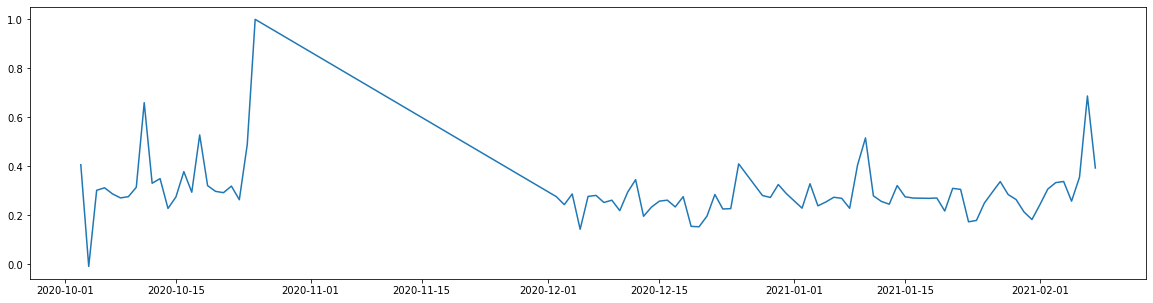

In [6]:
df_date_only = df.copy()
df_date_only["Time_Published"] = df["Time_Published"].dt.floor("d")
df_by_date = df_date_only.groupby(["Time_Published"], as_index=False).mean()
df_by_date.head()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(df_by_date["Time_Published"], df_by_date["Polarity"])

### Box plot for a date

In [7]:
import ipywidgets as widgets
wg = widgets.Dropdown(
    options=[(t.strftime("%Y-%m-%d"), t) for t in df_date_only["Time_Published"].drop_duplicates().to_list()],
    description='Date:'
)

out = widgets.Output()
display(out)
@out.capture()
def plot_box_plot(change):
    out.clear_output()
    df_date_only[df_date_only["Time_Published"] == wg.value].boxplot(column=["Polarity"])
    plt.show()

wg.on_displayed(plot_box_plot)
wg.observe(plot_box_plot, names=["value"])
display(wg)

Output()

Dropdown(description='Date:', options=(('2020-10-03', Timestamp('2020-10-03 00:00:00')), ('2020-10-04', Timest…

### Distribution of polarities

<BarContainer object of 3 artists>

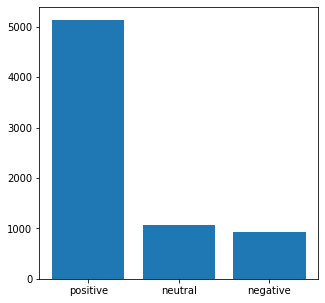

In [8]:
distr = {
    "positive": len(df[df["Sentiment"] == 1]),
    "neutral": len(df[df["Sentiment"] == 0]),
    "negative": len(df[df["Sentiment"] == -1]),
}

plt.figure(figsize=(5,5))
plt.bar(distr.keys(), distr.values())

So, the data is skewed towards the positive side (which is quite normal for crowdsourced sentiments like that on Stocktwits).

## Baseline using Zero Rule

In [9]:
print("Baseline accuracy:", max(distr.values()) / sum(distr.values()))

Baseline accuracy: 0.7200953582947693
